In [1]:
from csv import DictReader

with open('_data/properties_master.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows = [r for r in reader]
csv_file.close()

In [2]:
properties_to_use = [
    'properties.cetane_number.value',
    'properties.ysi_unified.value'
]

samples = []
for row in rows:
    use = True
    for prop in properties_to_use:
        if row[prop] == '-':
            use = False
            break
    if use:
        if float(row['properties.cetane_number.value']) > 100:
            continue
        samples.append(row)

print(len(samples))

145


In [3]:
import numpy as np
from sklearn.preprocessing import RobustScaler

data_cn = np.array([float(s['properties.cetane_number.value']) for s in samples]).reshape(-1, 1)
data_ysi = np.array([float(s['properties.ysi_unified.value']) for s in samples]).reshape(-1, 1)

scaler_cn = RobustScaler()
scaler_ysi = RobustScaler()
scaler_cn.fit(data_cn)
scaler_ysi.fit(data_ysi)
data_cn = scaler_cn.transform(data_cn)
data_ysi = scaler_ysi.transform(data_ysi)

targets = np.array(
    [[data_cn[i][0], data_ysi[i][0]] for i in range(len(data_ysi))]
)
print(targets.shape)

(145, 2)


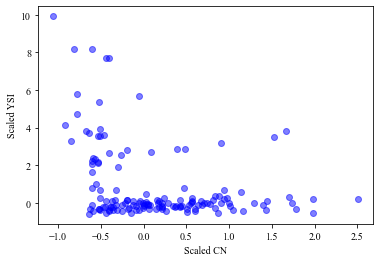

In [4]:
from matplotlib import pyplot as plt

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Scaled CN')
plt.ylabel('Scaled YSI')
plt.scatter(data_cn, data_ysi, color='blue', alpha=0.5)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from ecnet.datasets import QSPRDataset

smiles = [s['canonical_smiles'] for s in samples]
smiles_train, smiles_test, targets_train, targets_test = train_test_split(smiles, targets, test_size=0.25, random_state=24)

ds_train = QSPRDataset(smiles_train, targets_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, targets_test, backend='alvadesc')

In [6]:
from sklearn.decomposition import PCA
import torch

pca = PCA()
pca.fit(ds_train.desc_vals.detach().numpy())

ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_train.target_vals = ds_train.target_vals.type(torch.float32)

ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)
ds_test.target_vals = ds_test.target_vals.type(torch.float32)

In [7]:
from ecnet import ECNet
from sklearn.metrics import median_absolute_error, r2_score

train_maes_cn = []
train_maes_ysi = []
train_r2s_cn = []
train_r2s_ysi = []
test_maes_cn = []
test_maes_ysi = []
test_r2s_cn = []
test_r2s_ysi = []

exp_cn_train = [t[0] for t in targets_train]
exp_ysi_train = [t[1] for t in targets_train]
exp_cn_test = [t[0] for t in targets_test]
exp_ysi_test = [t[1] for t in targets_test]

for _ in range(25):

    _model = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 3)
    _, _ = _model.fit(dataset=ds_train, epochs=512, valid_size=0.25, shuffle=True, patience=16, verbose=0, lr=0.001)

    _pred_train = _model(ds_train.desc_vals).detach().numpy()
    _pred_test = _model(ds_test.desc_vals).detach().numpy()

    _p_cn_train = [p[0] for p in _pred_train]
    _p_ysi_train = [p[1] for p in _pred_train]
    _p_cn_test = [p[0] for p in _pred_test]
    _p_ysi_test = [p[1] for p in _pred_test]

    train_maes_cn.append(median_absolute_error(exp_cn_train, _p_cn_train))
    train_maes_ysi.append(median_absolute_error(exp_ysi_train, _p_ysi_train))
    train_r2s_cn.append(r2_score(exp_cn_train, _p_cn_train))
    train_r2s_ysi.append(r2_score(exp_ysi_train, _p_ysi_train))
    test_maes_cn.append(median_absolute_error(exp_cn_test, _p_cn_test))
    test_maes_ysi.append(median_absolute_error(exp_ysi_test, _p_ysi_test))
    test_r2s_cn.append(r2_score(exp_cn_test, _p_cn_test))
    test_r2s_ysi.append(r2_score(exp_ysi_test, _p_ysi_test))

In [8]:
import numpy as np

print(f'Training Set MAE, CN: {np.mean(train_maes_cn)} +/- {np.std(train_maes_cn)}')
print(f'Training Set MAE, YSI: {np.mean(train_maes_ysi)} +/- {np.std(train_maes_ysi)}')
print(f'Training Set R2, CN: {np.mean(train_r2s_cn)} +/- {np.std(train_r2s_cn)}')
print(f'Training Set R2, YSI: {np.mean(train_r2s_ysi)} +/- {np.std(train_r2s_ysi)}')
print(f'Test Set MAE, CN: {np.mean(test_maes_cn)} +/- {np.std(test_maes_cn)}')
print(f'Test Set MAE, YSI: {np.mean(test_maes_ysi)} +/- {np.std(test_maes_ysi)}')
print(f'Test Set R2, CN: {np.mean(test_r2s_cn)} +/- {np.std(test_r2s_cn)}')
print(f'Test Set R2, YSI: {np.mean(test_r2s_ysi)} +/- {np.std(test_r2s_ysi)}')

Training Set MAE, CN: 0.056347912343668496 +/- 0.027513288814490063
Training Set MAE, YSI: 0.048562772737076015 +/- 0.0419899482027523
Training Set R2, CN: 0.9624866457154782 +/- 0.043249418636269264
Training Set R2, YSI: 0.9927668243319465 +/- 0.010829315359233906
Test Set MAE, CN: 0.1939543568882449 +/- 0.033642247885827946
Test Set MAE, YSI: 0.0858557336981574 +/- 0.0427232786222323
Test Set R2, CN: 0.7398508479976487 +/- 0.05327790847404046
Test Set R2, YSI: 0.9187745605873187 +/- 0.024647349540653174


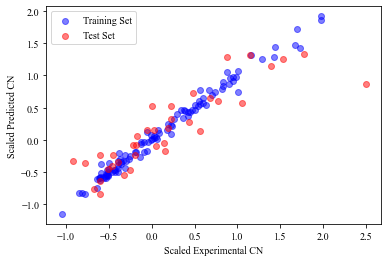

In [9]:
from matplotlib import pyplot as plt

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Scaled Experimental CN')
plt.ylabel('Scaled Predicted CN')
plt.scatter(exp_cn_train, _p_cn_train, color='blue', alpha=0.5, label='Training Set')
plt.scatter(exp_cn_test, _p_cn_test, color='red', alpha=0.5, label='Test Set')
plt.legend(loc='upper left')
plt.show()

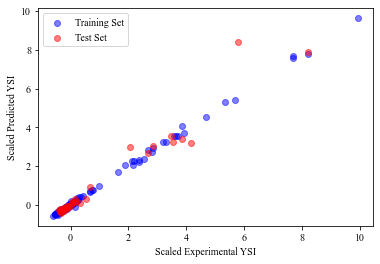

In [10]:
plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Scaled Experimental YSI')
plt.ylabel('Scaled Predicted YSI')
plt.scatter(exp_ysi_train, _p_ysi_train, color='blue', alpha=0.5, label='Training Set')
plt.scatter(exp_ysi_test, _p_ysi_test, color='red', alpha=0.5, label='Test Set')
plt.legend(loc='upper left')
plt.show()